# PyZLS: Zelus in Python

## A not so trivial first example
- Node application
- Automaton
- Parametric state

In [1]:
import pyzls

In [2]:
%%zelus -c

let node cpt i incr = o where 
    rec o = i fby o + incr

let node sawtooth(i) = o where
    rec init o = 0
    and automaton
      | Up -> do o = cpt 0 1 until (o > 10) then Down(o)
      | Down(i) -> do o = cpt 10 (-1) until (o < 1) then Up

In [3]:
t = sawtooth()
t.reset()  
[t.step(0) for _ in range(20)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import numpy as np

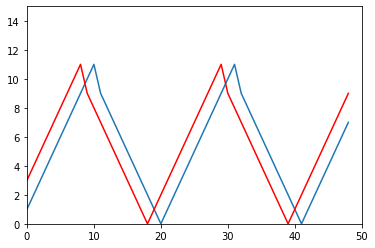

In [5]:
t2 = sawtooth()
t2.reset()

t3 = sawtooth()
t3.reset()
t3.step(0)
t3.step(0)

n = 50
t = np.arange(n)
p = []
pp = []
for i in range(n):
    clear_output(wait=True) 
    plt.plot(t[:i] , p)
    plt.plot(t[:i] , pp, 'r')
    plt.axis((0 , n , 0 , 15))
    plt.show() 
    p.append(t2.step(0))
    pp.append(t3.step(0))
#     time.sleep(0.01)

## Import python functions

- Extract python type signatures
- Compile zli interface
- Generate python module
- (also static parameters)

In [6]:
import pyzls

In [7]:
@pyzls.lib("bar")
def g(x: int, y:float) -> int:
    return x + y

@pyzls.lib("bar")
def gg(x: int, y:int) -> int:
    return g(x, y)

In [8]:
%%zelus

open Bar

let node sawtooth i p a = o where
    rec init o = 0
    and automaton
      | Up -> do o = gg(last o, 1) until (o > 10) then Down
      | Down -> do o = gg(last o, -1) until (o < 1) then Up

In [9]:
t = sawtooth(12)(5)()
t.reset()
[t.step(0) for _ in range(20)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]

In [10]:
@pyzls.lib("a")
def u(x: int, y: int) -> int:
    return x + y + 2

In [11]:
%%zelus

open A

let node sawtooth i p a = o where
    rec init o = 0
    and automaton
      | Up -> do o = u(last o, 1) until (o > 10) then Down
      | Down -> do o = u(last o, -1) until (o < 1) then Up

In [12]:
t = sawtooth(12)(5)()
t.reset()
[t.step(0) for _ in range(20)]

[3, 6, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

## Use imported python modules
- Example with numpy

In [13]:
import pyzls

In [14]:
@pyzls.lib("bar")
def foo(x: "'a") -> "'b":
    import numpy as np
    return np.arange(x)

In [15]:
%%zelus

open Bar

let node dummy i = o where
    rec o = foo(i)

In [16]:
d = dummy()
d.reset()
[d.step(i) for i in range(2, 10)]

[array([0, 1]),
 array([0, 1, 2]),
 array([0, 1, 2, 3]),
 array([0, 1, 2, 3, 4]),
 array([0, 1, 2, 3, 4, 5]),
 array([0, 1, 2, 3, 4, 5, 6]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8])]

In [17]:
foo(45)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

## ProbPyZLS

In [18]:
import pyzls
from infer_pf import Prob
import numpy as np
import pandas as pd

In [19]:
@pyzls.lib("dist")
def gaussian(*args: "'a") -> "'b":
    from torch.distributions import Normal
    return Normal(*args)

In [20]:
%%zelus -c -zopt "-I /Users/gbdrt/Projects/rppl/probzelus/inference" -zopt "-I ../lib"

open Dist
open Infer_pf

let proba kalman(x) = o where
     rec o = sample(gaussian(0. fby o, 2.))
     and _ = observe(gaussian(o, 4.), x)
     
let node tracker i = dist where
  rec dist = infer(100)(kalman)(i)

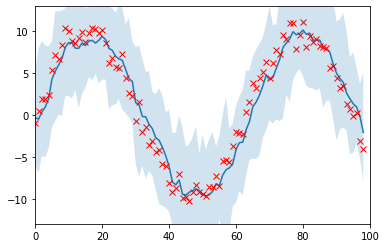

In [21]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

toto = tracker()
toto.reset()

n = 100
t = np.arange(n)
r = 10*np.sin(0.1*np.arange(n)) + np.random.randn(n)

s_min = []
s_mean = []
s_max = []


for i in range(n):
    clear_output(wait=True)
    plt.plot(t[:i] , s_mean)
    plt.plot(t[:i] , r[:i], 'xr')
    plt.fill_between(t[:i], s_min, s_max, alpha=0.2)
    plt.axis((0 , n , -13 , 13))
    plt.show()
    d = toto.step(r[i])
    s_min.append(np.min(d))
    s_mean.append(np.mean(d))
    s_max.append(np.max(d))
    